In [1]:
import numpy as np
from nbodykit.lab import *
from nbodykit.transform import CartesianToEquatorial
import healpy as hp
import h5py 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

root = 0
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

In [2]:
# general plot params
params = {'legend.fontsize': 18,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 24,
          'axes.formatter.use_mathtext' : True,   #ensures ticks follow math format. actually this doesn't work. We'll doit another time
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'font.family' : 'serif',
          #'font.serif' : 'cm',
          #'text.usetex' : True,
          'mathtext.fontset' : 'cm',
          'savefig.format' : 'pdf',
         }
plt.rcParams.update(params)

In [3]:
from colossus.cosmology import cosmology as colossus_cosmology
OmegaB = 0.0486 #0.046
OmegaM = 0.3089 #0.309167
OmegaC = OmegaM-OmegaB

h=0.6774
H0 = h*100
sigma8 = 0.8159
n_s = 0.9667 #the tilt of the primordial power spectrum
#As = 2e-09 * (sigma8/0.80258204)**2
params = {'flat': True, 'H0': H0, 'Om0': OmegaM, 'Ob0': OmegaB, 'sigma8': sigma8, 'ns': n_s, 'relspecies': True}#, 'powerlaw': True}
colossus_cosmology.addCosmology('myCosmo', **params)
colcosmo = colossus_cosmology.setCosmology('myCosmo')

# 2d test. Jump to below for 3d

In [4]:
nc = 512
sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % nc
prtl = BigFileCatalog(f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}/usmesh', dataset='1')

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [5]:
# obtain real field
mesh_name = f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/{sim}'
mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
mesh_kr = mesh_k.compute(mode='real', Nmesh=nc)   # Nmesh=nc takes care of x2 subsample

In [6]:
# mesh is delta+1, so subtract 1 to get delta
delta = mesh_kr[:].flatten() - 1 # unroll deltas

In [7]:
def read_range(cat, amin, amax):  # Yici gave this to me
    """ Read a portion of the lightcone between two red shift ranges
        The lightcone from FastPM is sorted in Aemit and an index is built.
        So we make use of that.
        CrowCanyon is z > 0; We paste the mirror image to form a full sky.
    """
    edges = cat.attrs['aemitIndex.edges']
    offsets = cat.attrs['aemitIndex.offset']
    start, end = edges.searchsorted([amin, amax])
    if cat.comm.rank == 0:
        cat.logger.info("Range of index is %d to %d" %(( start + 1, end + 1)))
    start = offsets[start + 1]
    end = offsets[end + 1]
    cat =  cat.query_range(start, end)
    #cat1 = cat.copy()
    #cat1['Position'] = cat1['Position'] * [1, 1, -1.]
    #cat3 = ConcatenateSources(cat, cat1)
    if cat.csize > 0:
        cat['RA'], cat['DEC'] = CartesianToEquatorial(cat['Position'], frame='galactic')
    else:
        cat['RA'] = 0
        cat['DEC'] = 0
    return cat  # returns RA, DEC in degrees

In [8]:
# get particle locations
amin, amax = 0.45, 0.55
cat = read_range(prtl, amin, amax)
nside = 128
npix = hp.nside2npix(nside)
hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [9]:
# get deltas based on particle ID
delta_at_particle = delta[np.array(cat['ID'])] 
delta_at_particle *= colcosmo.growthFactor(1/((amin+amax)/2)-1) / colcosmo.growthFactor(0) 

# set up some arrays for maps
particlemap, densitymap = np.zeros(npix), np.zeros(npix)

# add at pixel locations
np.add.at(particlemap, hp_ind, 1)
np.add.at(densitymap, hp_ind, delta_at_particle)

# normalize
particlemap = particlemap #/ np.mean(particlemap) - 1  # dont normalize!
densitymap = densitymap #/ np.mean(densitymap) #- 1

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [10]:
np.mean(particlemap)

250.0728556315104

In [11]:
np.sum(delta_at_particle) / len(cat["RA"])  # deltas are mean 1

0.0002591724895631815

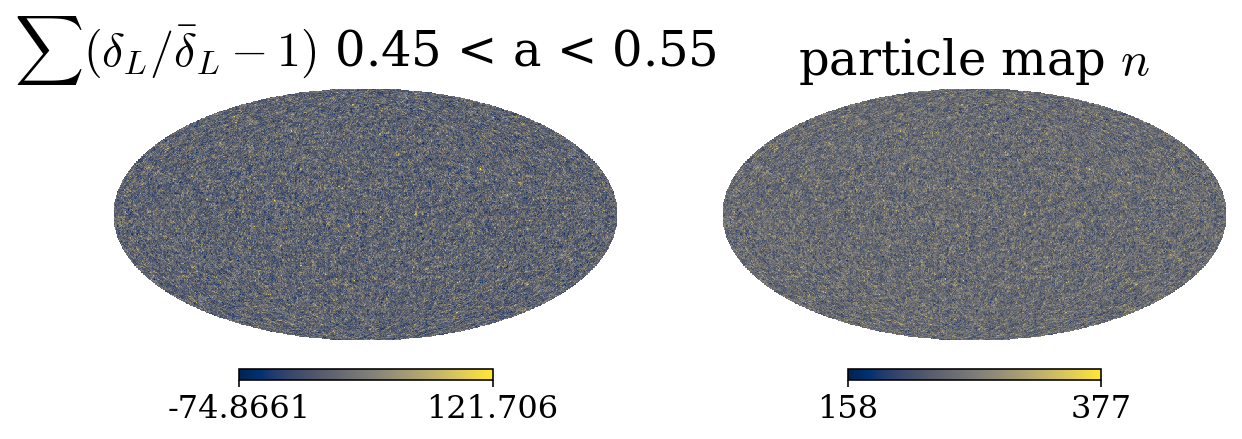

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.sca(ax[0])
hp.mollview(densitymap, cmap="cividis", hold=True,
            title=r"$\sum (\delta_L / \bar{\delta}_L-1)$ " + f"{amin} < a < {amax}")
plt.sca(ax[1])
hp.mollview(particlemap, cmap="cividis", hold=True,
            title="particle map $n$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

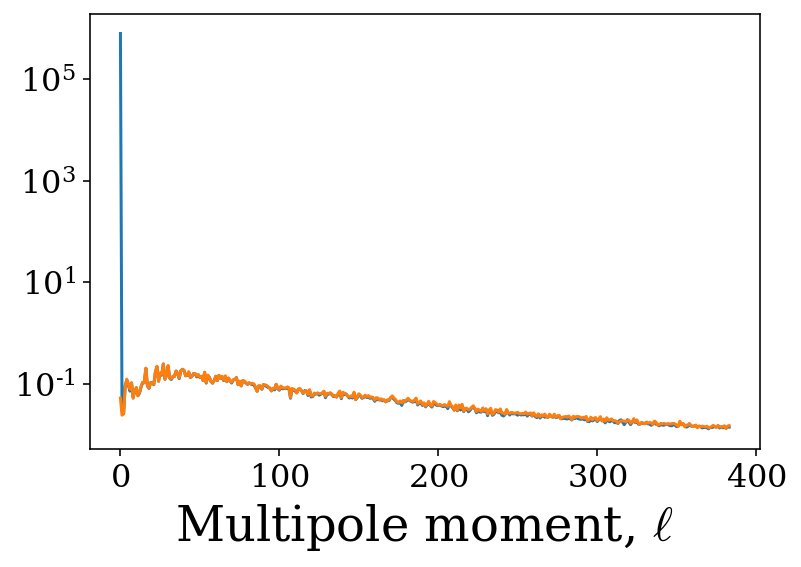

In [13]:
alm_particles = hp.map2alm(particlemap)
alm_density = hp.map2alm(densitymap)

plt.plot(hp.alm2cl(alm_particles), label="Auto-spectrum of particles, $n$")
plt.plot(hp.alm2cl(alm_density), label=r"Auto-spectrum $(\rho / \bar{\rho}-1)$ at particle locations")
# plt.plot(hp.alm2cl(alm_particles, alm_density), label=r"Cross-spectrum $n$ and $(\rho / \bar{\rho}-1)$")
plt.yscale("log"); plt.xlabel("Multipole moment, $\ell$")

Text(0.5, 0, 'Multipole moment, $\\ell$')

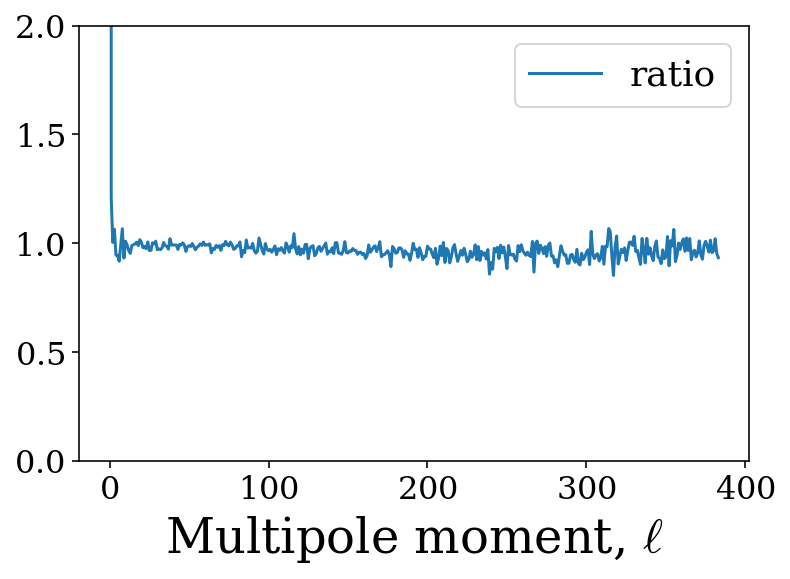

In [14]:
plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label="ratio")
plt.legend(); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtyp

Text(0.5, 0, 'Multipole moment, $\\ell$')

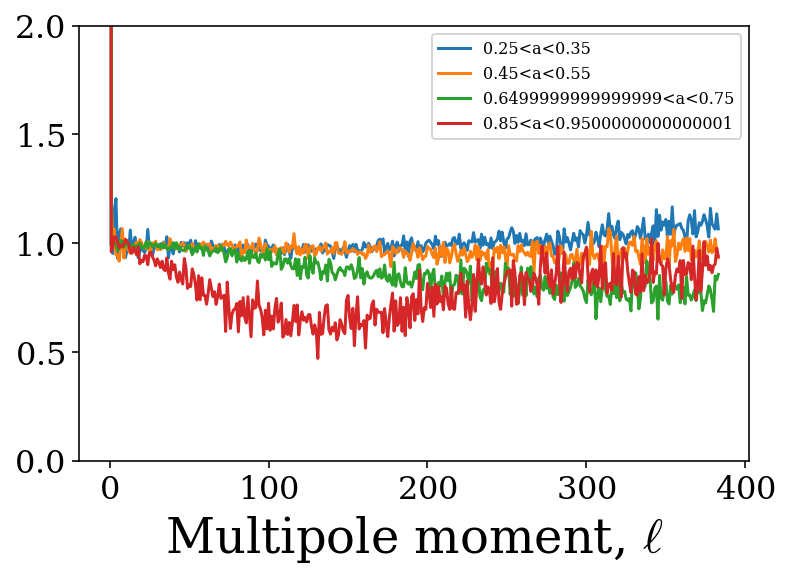

In [15]:
for a in (0.3, 0.5, 0.7, 0.9):
    amin, amax = a - 0.05, a + 0.05
    cat = read_range(prtl, amin, amax)
    hp_ind = hp.ang2pix(nside, cat["RA"], cat["DEC"], lonlat=True).compute()
    delta_at_particle = delta[np.array(cat['ID'])]
    delta_at_particle *= colcosmo.growthFactor(1/a-1) / colcosmo.growthFactor(0) # rescale by D
    particlemap, densitymap, shuffledensitymap = np.zeros(npix), np.zeros(npix), np.zeros(npix)
    np.add.at(particlemap, hp_ind, 1)
    np.add.at(densitymap, hp_ind, delta_at_particle)
    particlemap = particlemap #/ np.mean(particlemap) - 1 # DONT'T NORMALIZE
    densitymap = densitymap #/ np.mean(densitymap) - 1
    alm_particles = hp.map2alm(particlemap)
    alm_density = hp.map2alm(densitymap)
    plt.plot(hp.alm2cl(alm_particles) / hp.alm2cl(alm_density), label=f"{amin}<a<{amax}")
plt.legend(fontsize=8); plt.ylim(0,2); plt.xlabel("Multipole moment, $\ell$")

# 3d test (start from scratch, reload everything to avoid bugs)

In [16]:
import pmesh

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtyp

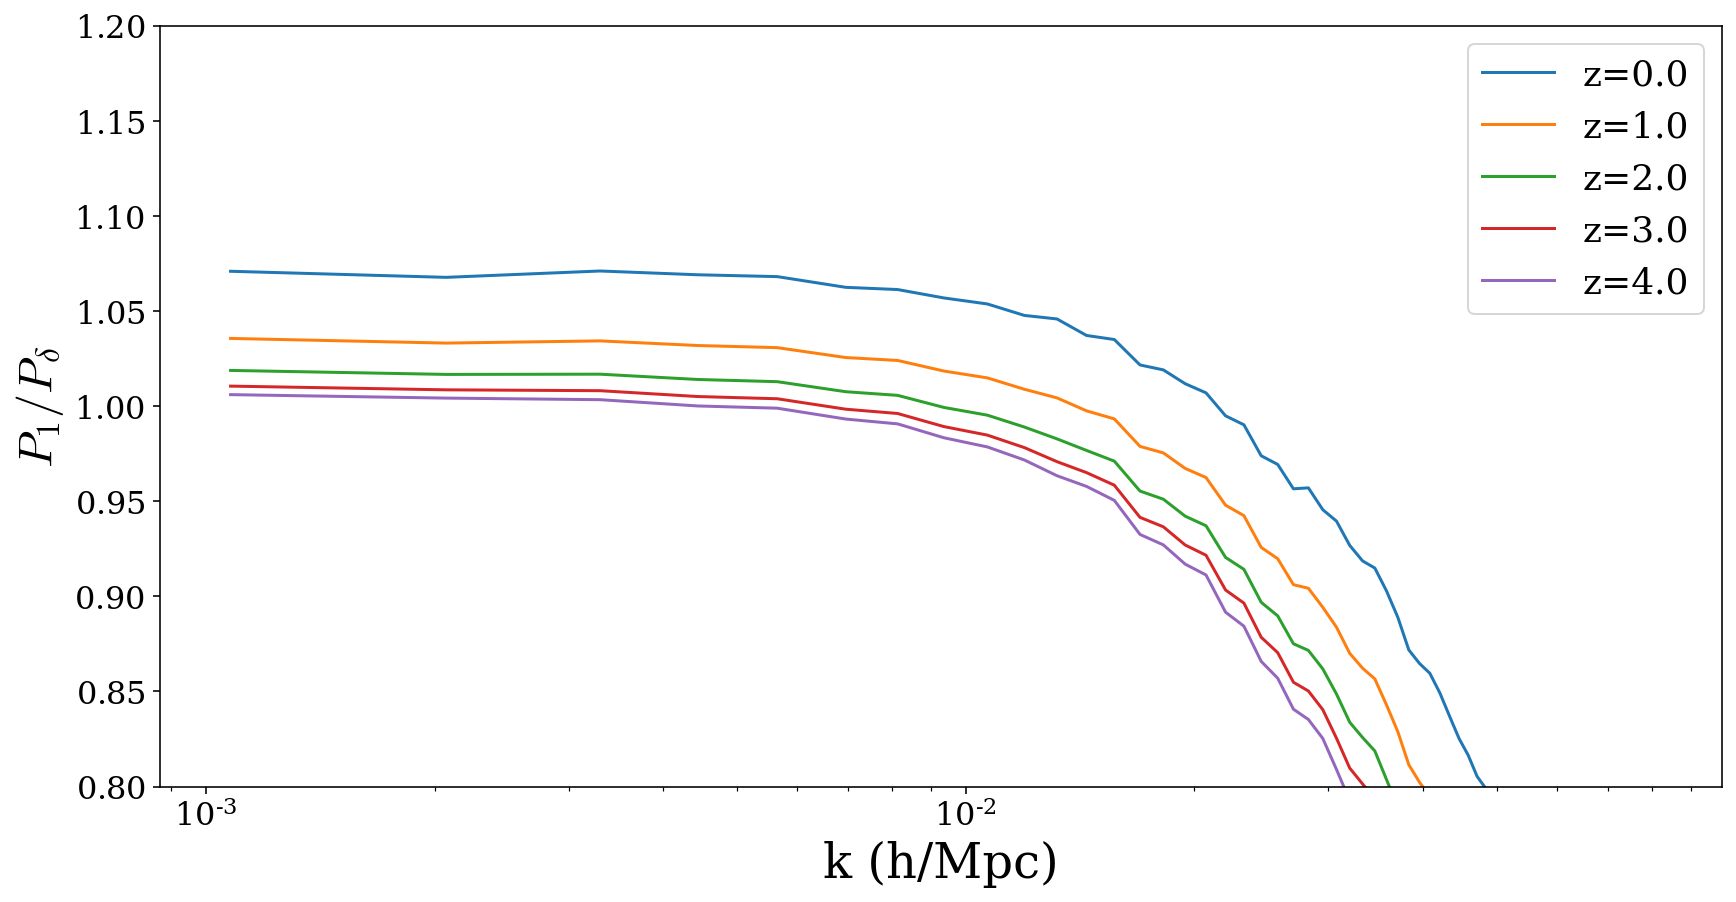

In [17]:
# unlike above, first interp delta1 onto NL particle positions, then use these values fo rmasses (as in marcels approach). hardly changes anything, apart form deviation at high k.
nc = 128
lpt_nc_factor = 2
pm_nc_factor = 2
bs = 5000

plt.figure(figsize=(14,7))
for z in [4, 3.5, 3, 2.5, 2.,1.5,1.,0.5,0.][::-2]:
    a = 1./(1+z)

    if nc == 128: mother = '/global/cfs/cdirs/mp107d/exgal/users/abayer/halfdome/ics/low_res/'
    else: mother = f'/global/cfs/cdirs/m3035/abayer/halfdome/ics/low_res/'
    sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf%d_lnf%d_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % (nc,pm_nc_factor,lpt_nc_factor)
    prtl_snap = BigFileCatalog(mother + f'{sim}/snapshot_%.4f'%a, dataset='1')
    

    assert(prtl_snap.comm.Get_size() == 1)

    mesh_name = mother + sim
    mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
    mesh_kr = mesh_k.compute(mode='real', Nmesh=nc)    # Need Nmesh <=nc. IF >nc (e.g. for lpt_nc_factor=2) get wrog results. Need to understand why. The ratio is 1, but is that sensible?

    delta = mesh_kr[:].flatten(order='C')  # unroll deltas, and subsample x2 from force grid  Try different deltas
    delta_at_particle_3d = delta[np.array(prtl_snap['ID'])]
    
    # delta is actually delta+1, so subtract 1 and rescale for z
    delta_at_particle_3d = (delta_at_particle_3d - 1) *  prtl_snap.attrs['GrowthFactor']
    
    # paint to 3d mesh
    Nmesh = 128
    pm = pmesh.pm.ParticleMesh([Nmesh, Nmesh, Nmesh], bs, dtype="float32")
    
    rho_particles = pm.paint(prtl_snap['Position'].compute(), mass=1)#nc**3)
    rho_density = pm.paint(prtl_snap['Position'].compute(), mass=delta_at_particle_3d)
    
    # compute power
    r_particles = FFTPower(rho_particles, mode='1d') #, dk=0.005, kmin=0.01)
    r_density = FFTPower(rho_density, mode='1d')
    #r_linear  = FFTPower(mesh_k, mode='1d')

    # ratio
    plt.semilogx(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real, label='z=%.1f'%z)
    #plt.semilogx(r_particles.power['k'][:int(Nmesh/2)], r_particles.power['power'].real/r_linear.power['power'].real[:int(Nmesh/2)], label='1/lin')
plt.legend()
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'$P_1 / P_\delta$')
plt.ylim(0.8,1.2)
plt.show()

### Testing below

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0 2.1798769012093544e-08 0.99999964 2.1811820010743388e-08


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0 1.3271346688270569e-08 0.99999964 1.3278488564248713e-08


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0 9.124050848186016e-09 0.99999964 9.136061811407476e-09


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0 6.912159733474255e-09 0.99999964 6.909428247474006e-09


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0 5.5442797020077705e-09 0.99999964 5.544376575831024e-09


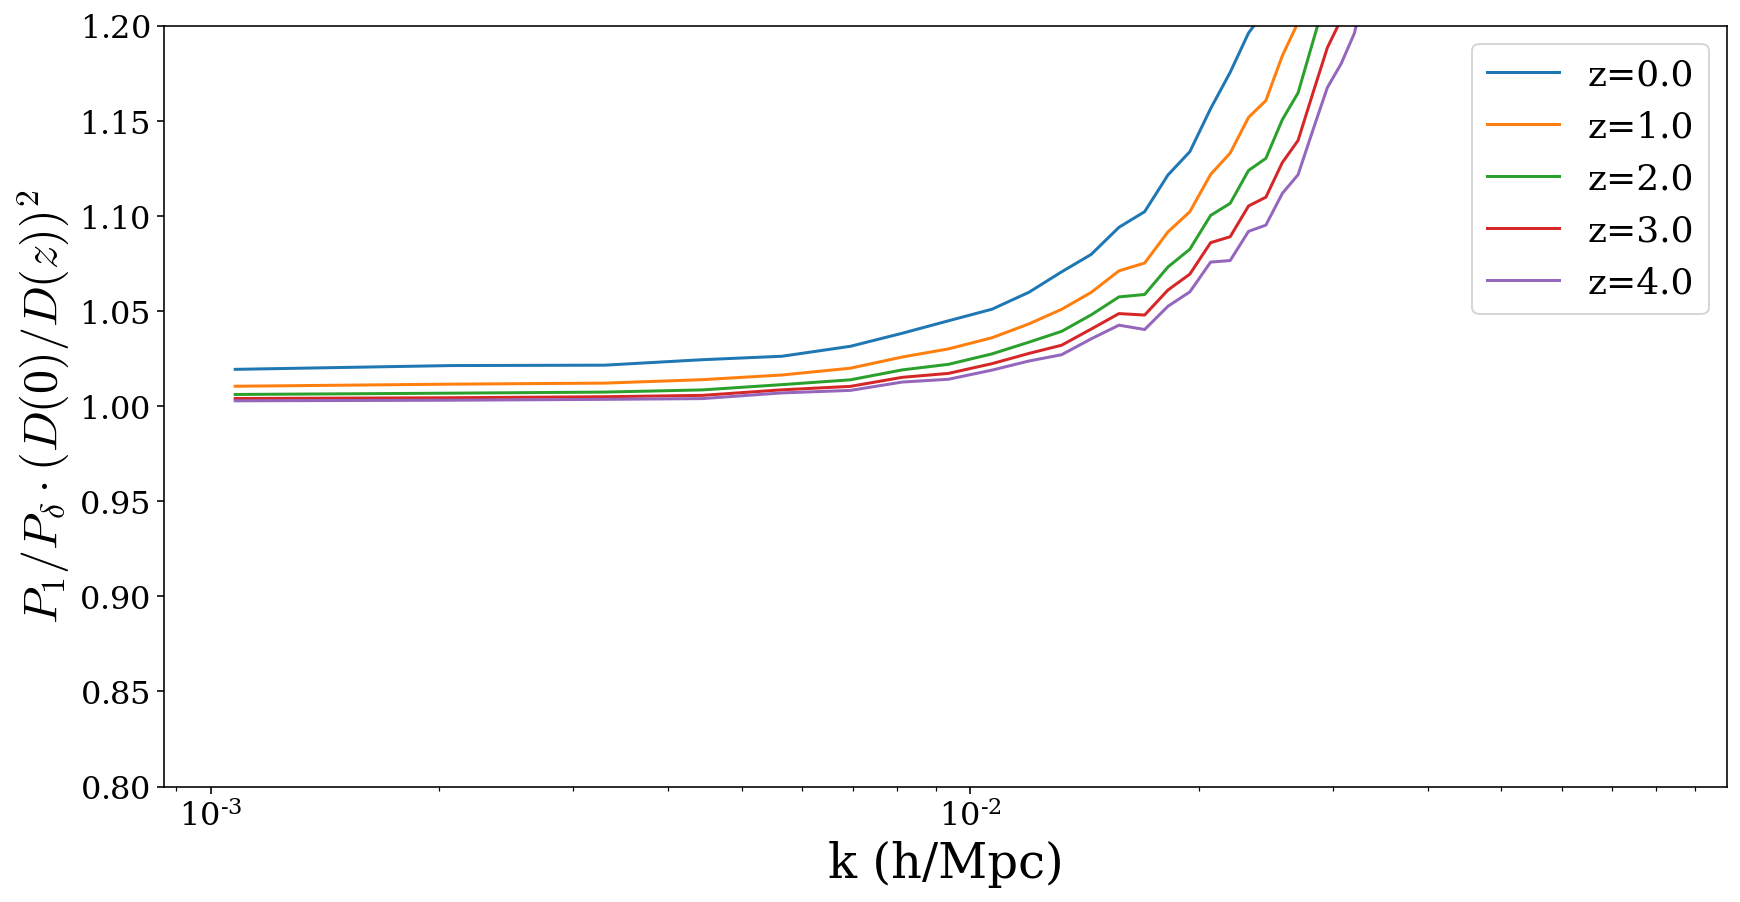

In [35]:
# unlike above, first interp delta1 onto NL particle positions, then use these values fo rmasses (as in marcels approach). hardly changes anything, apart form deviation at high k.
nc = 128
lpt_nc_factor = 2
pm_nc_factor = 2
bs = 5000

Nc = [nc,nc,nc]
_q_size = Nc[0] * Nc[1] * Nc[2]
_q_strides = np.empty(3, dtype=int)
_q_strides[0] = Nc[1] * Nc[2]
_q_strides[1] = Nc[2]
_q_strides[2] = 1
# can find the above in cat.attrs!

# make grid of grid points for readout:
# if USE_SHIFT was on when running fastpm, the particles are shifted bs/nc/2 ... but we ran with shift=false... hmm, what is this doing.
# store is filled on the basepm (not the lptpm) with the shift param. if shift=false, then shift=0. So gives shift=0, how does basepm look compared to lptpm?
# but all shift does is add an entre meta.q_shift !=0. so basically we should have no shift., and if we did we'd find it in meta._q_shift.
pts = np.arange(0,bs,bs/nc)          +bs/nc/2   # adding this makes a slight difference, can see clearly for lpt=pmnc=1, need this half shift! BUT from my reading of fastpm there is no shift (we're using shift=false), so we souldn't be doing this. also even after doing this it's not perfect.
lp = len(pts)
grid = np.zeros((lp,lp,lp,3))
grid[:,:,:,0] = pts[:,None,None]  #None is the same as np.newaxis
grid[:,:,:,1] = pts[None,:,None]
grid[:,:,:,2] = pts[None,None,:]

grid = grid.reshape(-1,3)

def get_IQ_from_ID(ID):
    """
    integer version of the initial position q
    i.e. the lattice coordinates of the cells.
    """
    pabs = np.empty(3, dtype=int)
    for d in range(3):
        pabs[d] = ID / _q_strides[d]
        ID -= pabs[d] * _q_strides[d]
    return pabs

plt.figure(figsize=(14,7))
for z in [4, 3.5, 3, 2.5, 2.,1.5,1.,0.5,0.][::-2]:
    a = 1./(1+z)
    sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf%d_lnf%d_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % (nc,pm_nc_factor,lpt_nc_factor)
    prtl_snap = BigFileCatalog(mother + f'{sim}/snapshot_%.4f'%a, dataset='1')

    assert(prtl_snap.comm.Get_size() == 1)

    mesh_name = mother + sim
    mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
    mesh_kr = mesh_k.compute(mode='real', Nmesh=nc)    # Need Nmesh <=nc. IF >nc (e.g. for lpt_nc_factor=2) get wrog results. Need to understand why. The ratio is 1, but is that sensible?

    
    delta = _delta[:].flatten(order='C')  # unroll deltas, and subsample x2 from force grid  Try different deltas
    
    # get deltas based on particle ID for 3d case
    #import warnings
    #warnings.filterwarnings("ignore")
    #IQ = [get_IQ_from_ID(ID) for ID in prtl_snap['ID'].compute()]
    
    delta_at_particle_3d = delta[np.array(prtl_snap['ID'])]
    ##delta_at_particle_3d = _delta[list(np.array(IQ).T)]

    #np.random.shuffle(delta_at_particle_3d)
    
    delta_at_particle_3d = mesh_kr.readout(grid)
    

    
    # delta is actually delta+1, so subtract 1 and rescale for z
    #Dratio = colcosmo.growthFactor(z) / colcosmo.growthFactor(0) 
    #print(Dratio, prtl_snap.attrs['GrowthFactor'])
    Dratio = prtl_snap.attrs['GrowthFactor']
    delta_at_particle_3d = (delta_at_particle_3d - 1)* Dratio #/lpt_nc_factor**0.5
    
    # paint to 3d mesh
    Nmesh = 128
    pm = pmesh.pm.ParticleMesh(
         [Nmesh, Nmesh, Nmesh], bs, dtype="float32")
    #shifted = pm.affine.shift(0.5)
    
    rho_particles = pm.paint(prtl_snap['Position'].compute(), mass=1)#nc**3)
    rho_density = pm.paint(prtl_snap['Position'].compute(), mass=delta_at_particle_3d)    # 
    
    print(rho_particles.cmean(), rho_density.cmean(), np.mean(delta), np.mean(delta_at_particle_3d))
    
    mesh_particles = rho_particles
    mesh_density = rho_density
    
    # compute power
    r_particles = FFTPower(mesh_particles, mode='1d') #, dk=0.005, kmin=0.01)
    r_density = FFTPower(mesh_density, mode='1d')
    #r_linear  = FFTPower(mesh_k, mode='1d')

    # ratio
    plt.semilogx(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real, label='z=%.1f'%z)
    #plt.semilogx(r_particles.power['k'][:int(Nmesh/2)], r_particles.power['power'].real/r_linear.power['power'].real[:int(Nmesh/2)], label='1/lin')
    plt.legend()

plt.xlabel('k (h/Mpc)')
if Dratio == 1:
    plt.ylabel(r'$P_1 / P_\delta$')
else:
    plt.ylabel(r'$P_1 / P_\delta \cdot (D(0)/D(z))^2$')
plt.ylim(0.8,1.2)
plt.show()

In [43]:
def id2q(pid, strides, scale, shift):
    ipos = pid[:, None] // strides[None, :]
    # the size of the highest dimension is unknown.
    sizes = (strides[:-1] // strides[1:])
    ipos[:, 1:] = ipos[:, 1:] % sizes
    pos = (ipos + shift) * scale
    return pos.astype("f8")

def main():
    ns = ap.parse_args()
    if ns.verbose:
        setup_logging('info')
    cat = BigFileCatalog(ns.catalog, dataset="1")
    params = FastPMParams(''.join(cat.attrs['ParamFile']), cwd=ns.cwd)

    if params['sigma8'] != 0:
        raise ValueError("overriding sigma8 is not supported")

    nmesh = ns.nmesh or params['nc']
    if cat.comm.rank == 0:
        cat.logger.info("Nmesh = %d", nmesh)

    strides = cat.attrs["q.strides"]
    scale = cat.attrs["q.scale"]
    shift = cat.attrs["q.shift"]

    pm = ParticleMesh([nmesh] * 3, cat.attrs['BoxSize'], comm=cat.comm)

    k, Pk = params.read_powerspectrum()
    def pklin(k_):
        return  numpy.interp(k_, k, Pk)
    def tf(k_):
        return (pklin(k_.normp(2, zeromode=1.0)**0.5) / pm.BoxSize.prod()**0.5)

    dlin = pm.generate_whitenoise(params['random_seed'],
                                unitary=params['remove_cosmic_variance'],
                                type='untransposedcomplex')
    dlin = dlin.apply(lambda k, v: tf(k) * v).c2r()

    if cat.comm.rank == 0:
        cat.logger.info("linear field generated.")

    Nchunks = max(cat.comm.allgather(cat.size)) // (4 * 1024 * 1024)
    Nchunks = max(1, Nchunks)

    if cat.comm.rank == 0:
        cat.logger.info("Nchunks = %d", Nchunks)

    ID = cat['ID']

    delta = numpy.empty(len(ID), dtype='f4')
    
    if cat.comm.rank == 0:
        cat.logger.info("delta allocated for %d particles.", cat.csize)

    def work(ID, i):
        if cat.comm.rank == 0:
            cat.logger.info("%d / %d", i, Nchunks)
        Q = id2q(ID, strides=strides, scale=scale, shift=shift)
        csize = cat.comm.allreduce(ID.size)
        if csize == 0:
            return numpy.zeros(len(Q), dtype='f4')
        cmin = numpy.min(cat.comm.allgather(Q.min(axis=0)), axis=0)
        cmax = numpy.max(cat.comm.allgather(Q.max(axis=0)), axis=0)
        if cat.comm.rank == 0:
            cat.logger.info("Q = [ %s ] - [ %s ], len(Q) = %d", cmin, cmax, csize)

        layout = pm.decompose(Q)
        if cat.comm.rank == 0:
            cat.logger.info("decompose finished.")
        delta = dlin.readout(Q, layout=layout)
        if cat.comm.rank == 0:
            cat.logger.info("readout done.")
        csum1 = cat.comm.allreduce(delta.sum())
        csum2 = cat.comm.allreduce((delta ** 2).sum())
        cmean = csum1 / csize
        cstd = (csum2 / csize - (csum1 / csize)**2) ** 0.5
        if cat.comm.rank == 0:
            cat.logger.info("On rank0, <delta> = %g, std(delta) = %g", cmean, cstd)
        return delta

    for i in range(Nchunks):
        chunk = slice(i * len(ID) // Nchunks, (i + 1) * len(ID) // Nchunks)
        delta[chunk] = work(ID[chunk].compute(), i)

    cat[ns.ocolumn] = delta

    if ns.ocatalog is None:
        ns.ocatalog = ns.catalog

    cat.save(ns.ocatalog, columns=[ns.ocolumn], header=None, dataset=ns.dataset)
    cat.comm.barrier()
    if cat.comm.rank == 0:
        cat.logger.info("done")

In [44]:
main()

NameError: name 'ap' is not defined

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead


1.0000001 0.98779297 0.99999994 0.99999994


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.608785341156588


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead


1.0 1.0117188 0.99999994 0.99999994


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.4188626770266718


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead


0.9999999 0.99560547 0.99999994 0.99999994


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.3167749875614054


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead


0.9999999 0.9746094 0.99999994 0.99999994


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.25418895190802254


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead


0.99999994 1.0053711 0.99999994 0.99999994


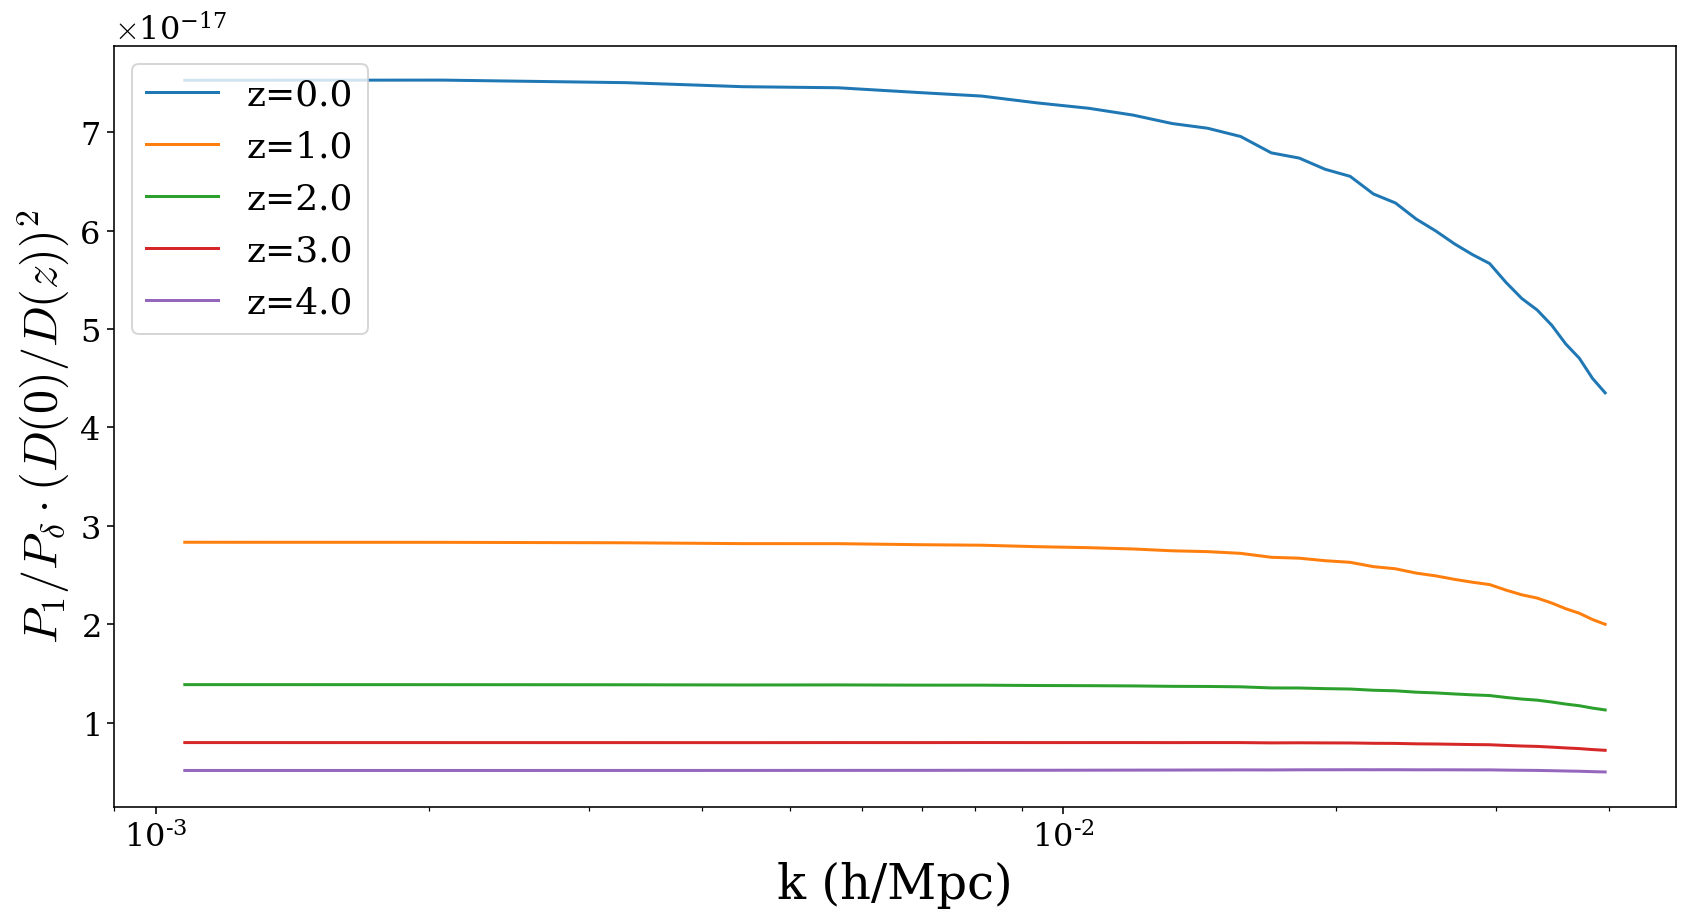

In [7]:
nc = 128
lpt_nc_factor = 1
pm_nc_factor = 1
bs = 5000

Nc = [nc,nc,nc]
_q_size = Nc[0] * Nc[1] * Nc[2]
_q_strides = np.empty(3, dtype=int)
_q_strides[0] = Nc[1] * Nc[2]
_q_strides[1] = Nc[2]
_q_strides[2] = 1

def get_IQ_from_ID(ID):
    """
    integer version of the initial position q
    i.e. the lattice coordinates of the cells.
    """
    pabs = np.empty(3, dtype=int)
    for d in range(3):
        pabs[d] = ID / _q_strides[d]
        ID -= pabs[d] * _q_strides[d]
    return pabs

plt.figure(figsize=(14,7))
for z in [4, 3.5, 3, 2.5, 2.,1.5,1.,0.5,0.][::-2]:
    a = 1./(1+z)
    sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf%d_lnf%d_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % (nc,pm_nc_factor,lpt_nc_factor)
    prtl_snap = BigFileCatalog(mother + f'{sim}/snapshot_%.4f'%a, dataset='1')

    assert(prtl_snap.comm.Get_size() == 1)

    #import warnings
    #warnings.filterwarnings("ignore")
    #IQ = [get_IQ_from_ID(ID) for ID in prtl_snap['ID'].compute()]

    mesh_name = mother + sim
    mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
    mesh_kr = mesh_k.compute(mode='real')

    _delta = mesh_kr[::lpt_nc_factor, ::lpt_nc_factor, ::lpt_nc_factor]
    delta = _delta.flatten(order='C')  # unroll deltas, and subsample x2 from force grid  Try different deltas

    # get deltas based on particle ID for 3d case
    delta_at_particle_3d = delta[np.array(prtl_snap['ID'])]
    #delta_at_particle_3d = _delta[list(np.array(IQ).T)]

    #np.random.shuffle(delta_at_particle_3d)

    # add column to catalog for delta_at_particle
    
    Dratio = colcosmo.growthFactor(z) / colcosmo.growthFactor(0)
    print(Dratio)
    
    prtl_snap['delta'] = (delta_at_particle_3d - 1) * Dratio # + 1) * (nc/Nmesh)**3 - 1

    # paint to 3d mesh
    Nmesh = 64
    mesh_particles = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True)
    mesh_density = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True, weight='delta')
    
    print(np.mean(mesh_particles.compute()), np.mean(mesh_density.compute()), np.mean(delta), np.mean(delta_at_particle_3d))
    
    # compute power
    r_particles = FFTPower(mesh_particles.compute(), mode='1d') #, dk=0.005, kmin=0.01)
    r_density = FFTPower(mesh_density.compute(), mode='1d')
    #r_linear  = FFTPower(mesh_k, mode='1d')

    """
    # plot power
    plt.loglog(r_particles.power['k'], r_particles.power['power'].real, label='n')
    plt.loglog(r_density.power['k'], r_density.power['power'].real, label='density weighted')
    plt.legend()
    plt.xlabel('k (h/Mpc)')
    plt.ylabel('P')
    """

    # ratio
    plt.semilogx(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real, label='z=%.1f'%z)
    #plt.semilogx(r_particles.power['k'][:int(Nmesh/2)], r_particles.power['power'].real/r_linear.power['power'].real[:int(Nmesh/2)], label='1/lin')
    plt.legend()

plt.xlabel('k (h/Mpc)')
if Dratio == 1:
    plt.ylabel(r'$P_1 / P_\delta$')
else:
    plt.ylabel(r'$P_1 / P_\delta \cdot (D(0)/D(z))^2$')
plt.show()

In [8]:
1/(Nmesh/nc)**3

8.0

/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


1.0
1.0 -9.823127766139805e-05 0.99999994 -9.823130105951125e-05


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.608785341156588
1.0 -5.980185233056545e-05 0.99999994 -5.980177612777003e-05


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.4188626770266718
1.0 -4.1145423892885447e-05 0.99999994 -4.114542572959981e-05


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.3167749875614054
1.0 -3.11172116198577e-05 0.99999994 -3.1117219171267276e-05


/global/common/software/m3058/abayer/conda/nbodykit/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


0.25418895190802254
1.0 -2.4969303922262043e-05 0.99999994 -2.4969311460878577e-05


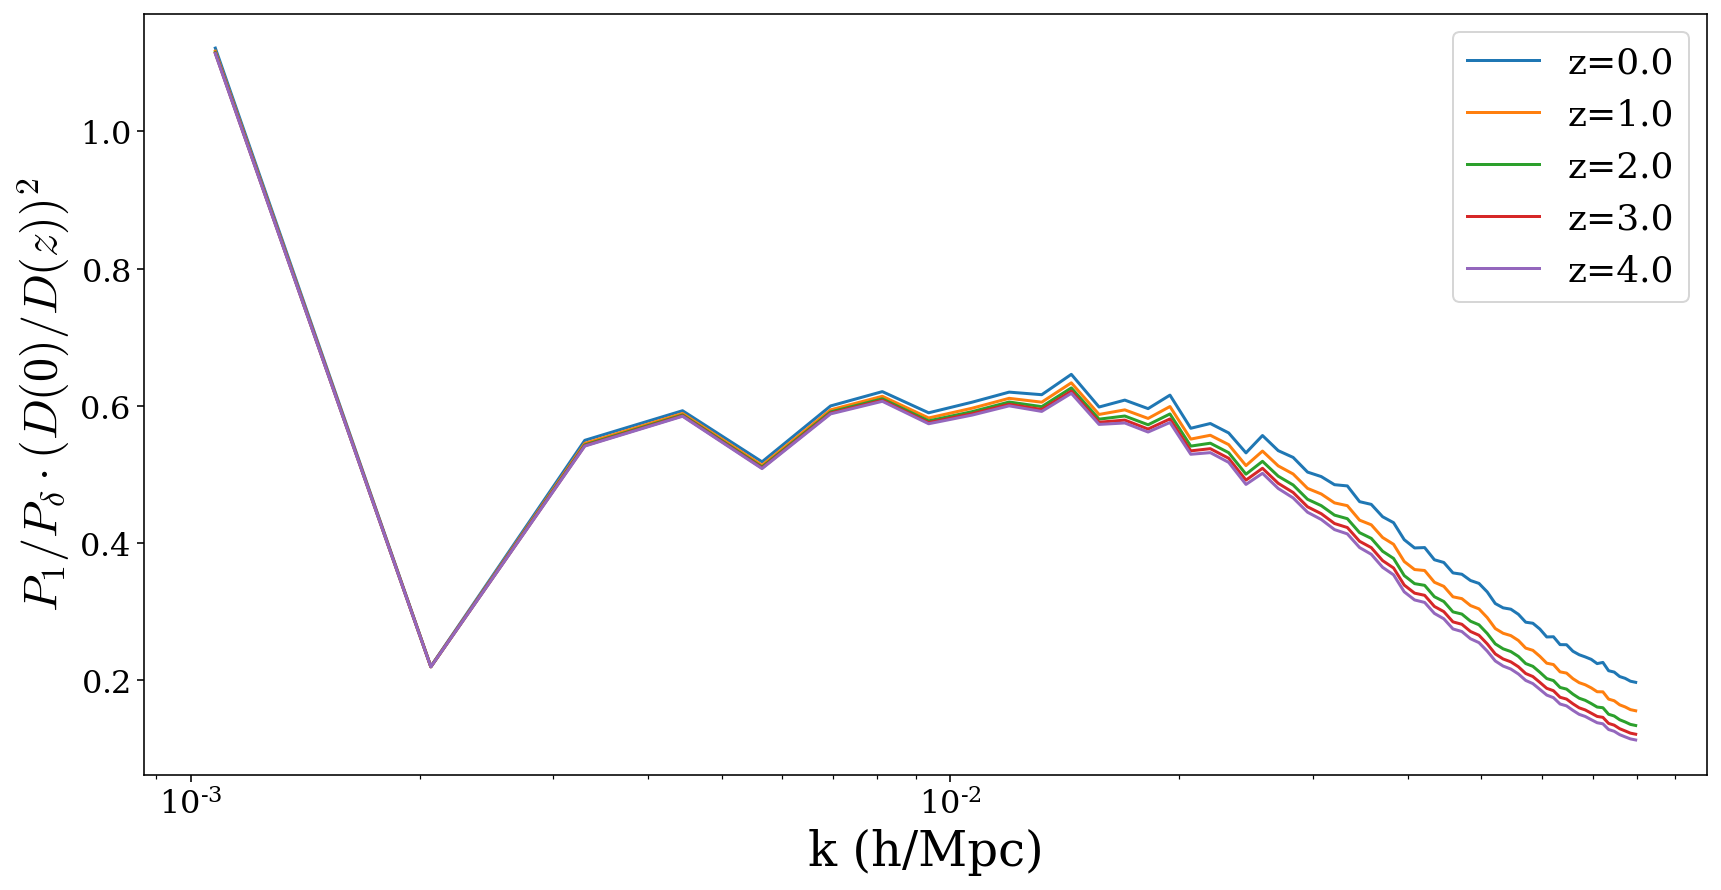

In [9]:
# unlike above, first interp delta1 onto NL particle positions, then use these values fo rmasses (as in marcels approach). hardly changes anything, apart form deviation at high k.
nc = 128
lpt_nc_factor = 2
pm_nc_factor = 2
bs = 5000

Nc = [nc,nc,nc]
_q_size = Nc[0] * Nc[1] * Nc[2]
_q_strides = np.empty(3, dtype=int)
_q_strides[0] = Nc[1] * Nc[2]
_q_strides[1] = Nc[2]
_q_strides[2] = 1

# make grid of grid points for readout:
pts = np.arange(0,bs,bs/nc)           +bs/nc/2   # adding this makes a slight difference, can see clearly for lpt=pmnc=1, need this half shift! So readout is more accurate then ::1. OR take avg I guess?
lp = len(pts)
grid = np.zeros((lp,lp,lp,3))
grid[:,:,:,0] = pts[:,None,None]  #None is the same as np.newaxis
grid[:,:,:,1] = pts[None,:,None]
grid[:,:,:,2] = pts[None,None,:]

grid = grid.reshape(-1,3)

def get_IQ_from_ID(ID):
    """
    integer version of the initial position q
    i.e. the lattice coordinates of the cells.
    """
    pabs = np.empty(3, dtype=int)
    for d in range(3):
        pabs[d] = ID / _q_strides[d]
        ID -= pabs[d] * _q_strides[d]
    return pabs

plt.figure(figsize=(14,7))
for z in [4, 3.5, 3, 2.5, 2.,1.5,1.,0.5,0.][::-2]:
    a = 1./(1+z)
    sim = 'rfof_proc64_nc%d_size5000_nsteps60lin_ldr0_rcvfalse_fstnone_pnf%d_lnf%d_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_2048_rfofkdt_8/' % (nc,pm_nc_factor,lpt_nc_factor)
    prtl_snap = BigFileCatalog(mother + f'{sim}/snapshot_%.4f'%a, dataset='1')

    assert(prtl_snap.comm.Get_size() == 1)

    #import warnings
    #warnings.filterwarnings("ignore")
    #IQ = [get_IQ_from_ID(ID) for ID in prtl_snap['ID'].compute()]

    mesh_name = mother + sim
    mesh_k = BigFileMesh(mesh_name+'lineark/', dataset='LinearDensityK')
    mesh_kr = mesh_k.compute(mode='real')

    # velow is attempt to take midpoint (i.e. avg), but better to use readout
    #_delta = mesh_kr[::lpt_nc_factor, ::lpt_nc_factor, ::lpt_nc_factor]
    #_delta = (mesh_kr[::lpt_nc_factor, ::lpt_nc_factor, ::lpt_nc_factor] + mesh_kr[1::lpt_nc_factor, 1::lpt_nc_factor, 1::lpt_nc_factor]) / 2
    #_delta = _delta.append(mesh_kr[0, 0, 0] + mesh_kr[-1, -1, -1::lpt_nc_factor]) / 2    # periodic bc
    #delta = _delta.flatten(order='C')  # unroll deltas, and subsample x2 from force grid  Try different deltas

    # get deltas based on particle ID for 3d case
    delta_at_particle_3d = delta[np.array(prtl_snap['ID'])]
    #delta_at_particle_3d = _delta[list(np.array(IQ).T)]
    # No we want delta at the particle positions, not on the grid points!

    #np.random.shuffle(delta_at_particle_3d)
    
    #glay, play = pm.decompose(grid), pm.decompose(pos)
    #pm.paint(pos, mass=d0.readout(grid, layout = glay, resampler='nearest'), layout=play)
    
    # get a layout (need window to determine buffer region)
    #layout = mesh_kr.pm.decompose(prtl_snap['Position'], smoothing='cic')

    # interpolate field to particle positions (use pmesh 'readout' function)
    #delta_at_particle_3d = mesh_kr.readout(prtl_snap['Position'].compute())#,
                            # resampler='cic',
                          #   layout=layout)
    delta_at_particle_3d = mesh_kr.readout(grid)
    
    #prtl_snap['delta'] = delta_at_particle_3d#+1

    # paint to 3d mesh
    Nmesh = 128
    
    Dratio = colcosmo.growthFactor(z) / colcosmo.growthFactor(0) 
    print(Dratio)
    
    delta_at_particle_3d = (delta_at_particle_3d - 1)* Dratio#/lpt_nc_factor**0.5  # mean is 1, so subtrac mean, then i.e. delta above is really delta+1 !!  /lpt_nc_factor**0.5 ???
    
    pm = pmesh.pm.ParticleMesh(
         [Nmesh, Nmesh, Nmesh], bs, dtype="float32")
    #shifted = pm.affine.shift(0.5)
    
    rho_particles = pm.paint(prtl_snap['Position'].compute(), mass=1)#nc**3)
    rho_density = pm.paint(prtl_snap['Position'].compute(), mass=delta_at_particle_3d)    # 
    
    print(rho_particles.cmean(), rho_density.cmean(), np.mean(delta), np.mean(delta_at_particle_3d))
    
    mesh_particles = rho_particles #/ rho_particles.cmean() -1
    mesh_density = rho_density #/ rho_density.cmean() 
    #mesh_particles = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True)
    #mesh_density = prtl_snap.to_mesh(window='tsc', Nmesh=Nmesh, compensated=True, value='delta')
    
    # compute power
    r_particles = FFTPower(mesh_particles, mode='1d') #, dk=0.005, kmin=0.01)
    r_density = FFTPower(mesh_density, mode='1d')
    #r_linear  = FFTPower(mesh_k, mode='1d')

    # ratio
    plt.semilogx(r_particles.power['k'], r_particles.power['power'].real/r_density.power['power'].real, label='z=%.1f'%z)
    #plt.semilogx(r_particles.power['k'][:int(Nmesh/2)], r_particles.power['power'].real/r_linear.power['power'].real[:int(Nmesh/2)], label='1/lin')
    plt.legend()

plt.xlabel('k (h/Mpc)')
if Dratio == 1:
    plt.ylabel(r'$P_1 / P_\delta$')
else:
    plt.ylabel(r'$P_1 / P_\delta \cdot (D(0)/D(z))^2$')
plt.show()

In [9]:
prtl_snap.columns


['ID', 'Position', 'Selection', 'Value', 'Velocity', 'Weight']

In [14]:
grid.shape

(128, 128, 128, 3)

In [18]:
1/.6

1.6666666666666667

In [30]:
2**.66666666666

1.5874010519608641